# 2 Data Wrangling

## 2.1 Introduction

__Purpose__: The purpose of this project is to use mobile phone accelerometer data to detect episodes of heavy drinking, i.e. when Blood Alcohol Concentration (BAC) > 8% for an individual. This detection method would be helpful and potentially life-saving when interventions are needed.

This data set from the UCI Machine Learning Repository contains data on 13 anonymized participants, each with 2 sets of data: Accelerometer data and TAC data. Transdermal Alcohol Concentration (TAC) was collected using SCRAM ankle bracelets, which functions like a breathalyzer for the ankle. The TAC data tells us when the participant was drunk (BAC > 8%). We can use this information in conjunction with the smartphone accelerometer data to teach a machine learning algorithm to classify when someone is or isn’t drunk. 

http://archive.ics.uci.edu/ml/datasets/Bar+Crawl%3A+Detecting+Heavy+Drinking

__Objective__: Clean the dataset and address issues like missing values and duplicate values. 
Apply data wrangling techniques, as laid out in the DSM of: Data Collection, Data Organization, Data Definition, Data Cleaning.

For this project, it is important to think of different ways to do outlier detection and smoothing. There is a method in pandas that allows us to implement a moving average as a smoothing technique. This would be worth testing.

In this notebook, we will load the data, join it into a pandas dataframe, plot the raw data, and plot several different x-day smoothing (e.g. 1 hr, 5hr).

## 2.2 Import Packages

In [103]:
# import packages

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

## 2.3 Load the Accelerometer Data

In [4]:
# change directories to where the raw data is located.

path = 'raw_data'
os.chdir(path)
os.getcwd()

'C:\\Users\\grace\\Documents\\Data Science Bootcamp\\DSC-projects\\Capstone 2\\Heavy drinking project\\raw_data'

In [5]:
# save as pandas df: all_accelerometer_data_pids_13
acc = pd.read_csv('all_accelerometer_data_pids_13.csv')

# check the first few rows to see if it loaded correctly
acc.head()

,time,pid,x,y,z
0,0,JB3156,0.0000,0.0000,0.0000
1,0,CC6740,0.0000,0.0000,0.0000
2,1493733882409,SA0297,0.0758,0.0273,-0.0102
3,1493733882455,SA0297,-0.0359,0.0794,0.0037
4,1493733882500,SA0297,-0.2427,-0.0861,-0.0163


In [6]:
# check a summary of the df. 
acc.info()

# We note that "time" is an int, the accelerometer data is float, and pid is object. This makes sense.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14057567 entries, 0 to 14057566
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   time    int64  
 1   pid     object 
 2   x       float64
 3   y       float64
 4   z       float64
dtypes: float64(3), int64(1), object(1)
memory usage: 536.3+ MB


In [7]:
# check to see if there are any NaN values.
acc.isna().sum() 

# We note that there are no NaN values.

time    0
pid     0
x       0
y       0
z       0
dtype: int64

In [40]:
# Check to see if the accelerometer data has exactly 13 anonymized individuals for pid.
# Note: pid stands for "Participant ID"

pid_list = list(acc['pid'].unique())
pid_list.sort()
pid_list

# There are indeed 13 anonymized individuals.

['BK7610',
 'BU4707',
 'CC6740',
 'DC6359',
 'DK3500',
 'HV0618',
 'JB3156',
 'JR8022',
 'MC7070',
 'MJ8002',
 'PC6771',
 'SA0297',
 'SF3079']

In [41]:
# Check to see the number of instances under each individuals.
# This is to make see if our individuals have roughly the same amount of accelerometer data, 
# and we don't have an imbalanced dataset.

# make an empty dictionary

pid_instances = {}

for i in pid_list:
    pid_instances[i] = (acc.pid.values == i).sum()
    
pid_instances

{'BK7610': 1225727,
 'BU4707': 447423,
 'CC6740': 2374695,
 'DC6359': 591358,
 'DK3500': 1339622,
 'HV0618': 1876013,
 'JB3156': 1177749,
 'JR8022': 307526,
 'MC7070': 318600,
 'MJ8002': 631303,
 'PC6771': 2141701,
 'SA0297': 962901,
 'SF3079': 662949}

<BarContainer object of 13 artists>

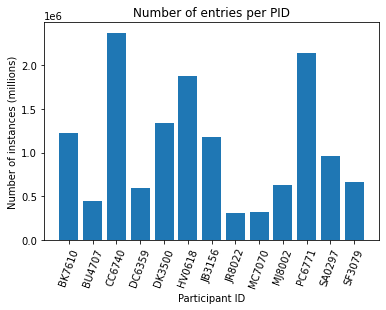

In [42]:
plt.xticks(rotation=70)
plt.xlabel('Participant ID')
plt.ylabel('Number of instances (millions)')
plt.title('Number of entries per PID')
plt.bar(pid_instances.keys(), pid_instances.values())

We have found that the accelerometer data contains 14 million (14057567) entries and 5 columns: time, pid, x, y, z. There are no missing values. The data is a concatenation of the 13 individuals' cell phone accelerometer data. Some individuals had as few as 300k instances while others had > 2 million. This might not be an issue--the main thing we care about is whether we have enough TAC data that's both above and below 8% so that we have enough drunk/sober datapoints to train our model.

In the next step, we will need to load the TAC Data and join it to our accelerometer data. I have noticed that the dataset takes 536.3+ MB memory, manipulating the data becomes very time-consuming and cumbersome. It may be more time-efficient (for now) to join subsets of the accelerometer data to each individuals' TAC data instead. We would work with 13 smaller dataframes, rather than 1 large one.

## 2.4 Load the TAC Data

In [31]:
# change directories to where clean TAC (transdermal alcohol concentration) is located.
path = 'clean_tac'
os.chdir(path)

In [32]:
# save as pandas df, each clean_TAC file for each participant, total of 13.
pid1 = pd.read_csv('BK7610_clean_TAC.csv')
pid2 = pd.read_csv('BU4707_clean_TAC.csv')
pid3 = pd.read_csv('CC6740_clean_TAC.csv')
pid4 = pd.read_csv('DC6359_clean_TAC.csv')
pid5 = pd.read_csv('DK3500_clean_TAC.csv')
pid6 = pd.read_csv('HV0618_clean_TAC.csv')
pid7 = pd.read_csv('JB3156_clean_TAC.csv')
pid8 = pd.read_csv('JR8022_clean_TAC.csv')
pid9 = pd.read_csv('MC7070_clean_TAC.csv')
pid10 = pd.read_csv('MJ8002_clean_TAC.csv')
pid11 = pd.read_csv('PC6771_clean_TAC.csv')
pid12 = pd.read_csv('SA0297_clean_TAC.csv')
pid13 = pd.read_csv('SF3079_clean_TAC.csv')

In [33]:
# We take a look at the first few lines of pid1.
pid1.head()

,timestamp,TAC_Reading
0,1493718714,-0.000482
1,1493720697,0.001573
2,1493721027,0.002144
3,1493721357,0.000877
4,1493721686,-0.001145


In [72]:
# It looks like we don't have the participant ID in the df.
# It would be helpful to have a pid column to merge on.
# Let's add a pid column for each df. We can make a list of the df's and use pid_list (which is alphabetised).
# (This works because pid_list is alphabetical, and we loaded the df's alphabetically.)

pid_cleanTAC_list = [pid1, pid2, pid3, pid4, pid5, pid6, pid7, pid8, pid9, pid10, pid11, pid12, pid13]

for i in range(13):
    pid_cleanTAC_list[i]['pid'] = pid_list[i]

In [80]:
pid13.head()
# This looks like the pid column was inputted correctly.

,timestamp,TAC_Reading,pid
0,1493722490,-0.008826,SF3079
1,1493724435,-0.014854,SF3079
2,1493724750,-0.012176,SF3079
3,1493725064,0.000510,SF3079
4,1493725378,0.015509,SF3079


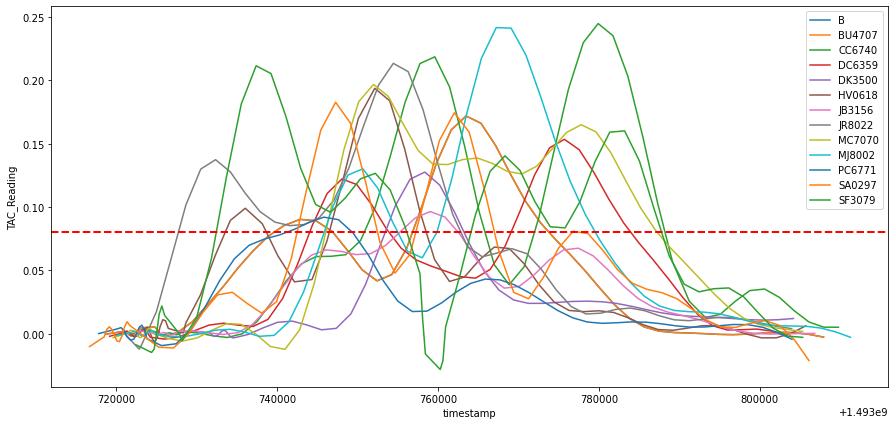

In [91]:
#Let's plot the clean_TAC to see how our drinking data looks versus time.

fig, ax = plt.subplots(figsize=(15,7))

for i in range(13):
    sns.lineplot(data=pid_cleanTAC_list[i], x=pid_cleanTAC_list[i].timestamp, y=pid_cleanTAC_list[i].TAC_Reading, 
                 label=pid_cleanTAC_list[i].pid[0])

plt.axhline(y=0.08, linewidth=2, color='r', linestyle='--')
plt.legend(loc='upper right')
plt.show()

The transdermal alcohol content (TAC) of the 13 individuals can be seen above. There are instances where TAC falls below 0.00, which we know it's impossible to have a negative blood alcohol content (BAC). This can be explained by the fact that SCRAM bracelets are not sensitive in detecting alcohol concentrations at low TAC levels. 

The red dashed line is the 8% BAC level, where one is considered legally intoxicated at or above that level. There appears to be a good number of instances above that level, which we could use to train our data.

We should look into how much of the data is at or above 8%, and how much is below, for each individual. This may be important later in deciding how we want to split our train/test data.

In [115]:
# Check to see the number of instances above or below 8% TAC for each individual.
# This is to make see if we have similar number of events in both classes and we don't have an imbalanced dataset.
# We can do what we did with the accelerometer data in the previous section.

pid_TAC_instances = {}

for i in range(13):
    pid_TAC_instances[pid_list[i]] = [(pid_cleanTAC_list[i].TAC_Reading.values >=0.08).sum(),
                                      (pid_cleanTAC_list[i].TAC_Reading.values <0.08).sum(),
                                      (pid_cleanTAC_list[i].TAC_Reading.count())]
    
pid_TAC_instances

{'BK7610': [13, 44, 57],
 'BU4707': [13, 44, 57],
 'CC6740': [17, 39, 56],
 'DC6359': [14, 41, 55],
 'DK3500': [5, 46, 51],
 'HV0618': [9, 45, 54],
 'JB3156': [4, 51, 55],
 'JR8022': [19, 28, 47],
 'MC7070': [23, 33, 56],
 'MJ8002': [16, 43, 59],
 'PC6771': [4, 52, 56],
 'SA0297': [11, 47, 58],
 'SF3079': [26, 28, 54]}

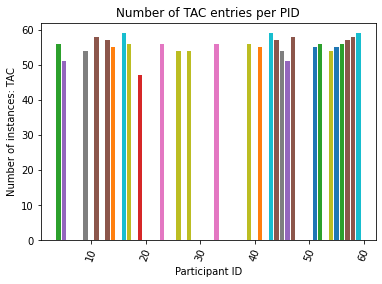

In [127]:
plt.xticks(rotation=70)
plt.xlabel('Participant ID')
plt.ylabel('Number of instances: TAC')
plt.title('Number of TAC entries per PID')
for i in range(13):
    for j in range(3):
        plt.bar(pid_TAC_instances[pid_list[i]], pid_TAC_instances[pid_list[i]][j])


In [121]:
pid_TAC_instances[pid_list[1]][2]

57

In [126]:
keys = pid_TAC_instances.keys()
vals = pid_TAC_instances.values()

vals

dict_values([[13, 44, 57], [13, 44, 57], [17, 39, 56], [14, 41, 55], [5, 46, 51], [9, 45, 54], [4, 51, 55], [19, 28, 47], [23, 33, 56], [16, 43, 59], [4, 52, 56], [11, 47, 58], [26, 28, 54]])